# Power manifold results

## Setup

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score


## Helper functions

In [2]:
def plot_w_err(x, yvals, ls="-", m=" ", ms=6., c="black", label=None, alpha=0.1, subtract_min=False, **kwargs):
    y_mean, y_err = np.nanmean(yvals, axis=1), np.nanstd(yvals, axis=1)
    if subtract_min:
        y_mean -= np.min(y_mean)
        
    plt.fill_between(x, y_mean - y_err, y_mean + y_err, color=c, alpha=alpha)
    plt.plot(x, y_mean, label=label, ls=ls, marker=m, ms=ms, c=c, **kwargs)

In [3]:
def histo_w_err(
    xvals, xmin, xmax, nbins,
    ls="-", m=" ", ms=6., c="black",
    label=None, alpha=0.1,
    subtract_min=False, plot_individual=False,
    **kwargs
):
    # Calculate histograms
    histos = []
    for x in xvals:
        histo, bin_edges = np.histogram(x, bins=nbins, range=(xmin, xmax), density=True)
        histos.append(histo)
    histos = np.array(histos)

    # Mean and error band
    y_mean, y_err = np.nanmean(histos, axis=0), np.nanstd(histos, axis=0)
    
    x_ = np.repeat(bin_edges, 2)[1:-1]
    y_ = np.repeat(y_mean, 2)
    y_err_ = np.repeat(y_err, 2)
    yis_ = [np.repeat(y, 2) for y in histos]
    
    # Plot
    plt.fill_between(x_, y_ - y_err_, y_ + y_err_, color=c, alpha=alpha)
    plt.plot(x_, y_, label=label, ls=ls, marker=m, ms=ms, c=c, lw=1.5, **kwargs)
    
    if plot_individual:
        for yi_ in yis_:
            plt.plot(x_, yi_, ls=ls, lw=0.5, c=c)
    

## Load results

In [4]:
n_runs = 3
remove_all_results_with_nans = True

In [5]:
algo_filenames = []
algo_additionals = []
algo_labels = []
algo_colors = []
algo_markers = []
algo_linestyles = []

def add_algo(filename, add, label, c, m, ls):
    algo_filenames.append(filename)
    algo_additionals.append(add)
    algo_labels.append(label)
    algo_colors.append(c)
    algo_markers.append(m)
    algo_linestyles.append(ls)
    
add_algo("flow", "_march", "EF", "C0", "s", "-")
add_algo("pie", "_march", "PIE", "C4", "s", "--") 
add_algo("mf", "_march", "MLF-S", "C3", "s", "--")
add_algo("mf", "_alternate_march", "MLF-A", "C3", "s", "-")
add_algo("gamf", "_march", "MLF-OT", "C1", "s", "--") 
add_algo("gamf", "_alternate_march", "MLF-OTA", "C1", "s", "-") 
add_algo("emf", "_march", "EMLF-S", "C2", "s", "--")
add_algo("emf", "_alternate_march", "EMLF-A", "C2", "s", "-")


In [6]:
def load(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add in zip(algo_filenames, algo_additionals):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)
            try:
                this_result = np.load(
                    "{}/{}_2_power{}{}_{}.npy".format(
                        result_dir, algo_filename, algo_add, run_str, name
                    )
                )
                if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                    algo_results.append(this_result.reshape(shape))
                else:
                    print(this_result.shape, shape)
                    algo_results.append(np.nan*np.ones(shape))
                    
            except FileNotFoundError as e:
                if shape is None:
                    algo_results.append(None)
                else:
                    algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    if numpyfy:
        all_results = np.array(all_results, dtype=np.float)
        
    return all_results


model_gen_x = load("samples", None, numpyfy=False)
model_gen_logp = load("samples_likelihood", (10000,))
model_gen_distance = load("samples_manifold_distance", (10000,))
model_test_logp = load("model_log_likelihood_test", (101, 1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))
model_ood_logp = load("model_log_likelihood_ood", (101, 1000,))
model_ood_reco_error = load("model_reco_error_ood", (1000,))
model_posterior_samples = load("posterior_samples", (5000, 1,))
model_mmds = load("mmd", (1,))


(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)
(11, 1000) (101, 1000)


In [7]:
def remove_nans(*results):
    passes = all([np.all(np.isfinite(result)) for result in results])
    
    if passes:
        return results
    else:
        return [np.nan * np.ones_like(result) for result in results]


def remove_nans_from_lists(*raws):
    # raws[quantity][algo]
    n_quantities = len(raws)
    n_algos = len(raws[0])
    
    for raw in raws:
        assert len(raw) == n_algos
    
    cleans = [[[] for _ in range(n_algos)] for _ in range(n_quantities)]
    
    for i in range(n_algos):
        for k in range(n_runs):
            clean = remove_nans(*[raw[i][k] for raw in raws])
            for j in range(n_quantities):
                cleans[j][i].append(clean[j])
            
    cleans = [np.array(clean) for clean in cleans]
    
    # cleans[quantity][algo]
    return cleans
            
    
if remove_all_results_with_nans:
    raw = [model_gen_logp, model_gen_distance, model_test_logp, model_ood_logp, model_ood_reco_error, model_posterior_samples, model_mmds]
    clean = remove_nans_from_lists(*raw)
    model_gen_logp, model_gen_distance, model_test_logp, model_ood_logp, model_ood_reco_error, model_posterior_samples, model_mmds = clean


In [8]:
def load_truth(name, samples=True):
    if samples:
        return np.asarray([
            np.load("../data/samples/power/{}{}.npy".format(
                name, run_str
            ))
            for run_str in [""] + ["_run{}".format(i) for i in range(1, n_runs)]
        ])
    else:
        return np.asarray([
            np.load("../data/results/truth_power{}_{}.npy".format(
                run_str, name
            ))
            for run_str in [""] + ["_run{}".format(i) for i in range(1, n_runs)]
        ])

test_x = load_truth("x_test", True)
test_distance = np.zeros((test_x.shape[0], 1))
test_logp = load_truth("true_log_likelihood_test", False)
true_posterior_samples = load_truth("posterior_samples", False)

param_grid = np.linspace(-1, 1, 101)


## Calculate metrics

In [9]:
n_observed = 20
min_logp = -100.
max_distance = 10.

model_gen_mean_logp = np.mean(np.clip(model_gen_logp, min_logp, None), axis=2)
model_gen_mean_distance = np.mean(np.clip(model_gen_distance, None, max_distance), axis=2)
model_observed_nll = -2. * np.sum(model_test_logp[:,:,:,:n_observed], axis=-1)

test_mean_logp = np.mean(np.clip(test_logp, min_logp, None), axis=1)
test_mean_distance = np.mean(np.clip(test_distance, None, max_distance), axis=1)
true_observed_nll = -2. * np.sum(test_logp[:,:,:n_observed], axis=-1)


In [10]:
def calculate_roc_auc(x0, x1):
    assert x0.shape == x1.shape
    old_shape = x0.shape[:-1]
    x0 = x0.reshape(-1, x0.shape[-1])
    x1 = x1.reshape(-1, x1.shape[-1])
    
    aucs = []
    for x0_, x1_ in zip(x0, x1):
        if not np.all(np.isfinite(np.hstack((x0_, x1_)))):
            aucs.append(np.nan)
            continue
            
        auc = roc_auc_score(
            np.hstack((np.zeros(x0_.shape[0], dtype=np.int), np.ones(x1_.shape[0], dtype=np.int))),
            np.hstack((x0_, x1_)),
        )
        auc_flipped = roc_auc_score(
            np.hstack((np.zeros(x0_.shape[0], dtype=np.int), np.ones(x1_.shape[0], dtype=np.int))),
            - np.hstack((x0_, x1_)),
        )
        aucs.append(max(auc, auc_flipped))
        
    aucs = np.asarray(aucs)
    aucs = aucs.reshape(old_shape)
    return aucs


model_auc_logp = calculate_roc_auc(model_test_logp[:,:,50,:], model_ood_logp[:,:,50,:])
model_auc_err = calculate_roc_auc(model_test_reco_error, model_ood_reco_error)
model_auc_use_err = (model_auc_err > model_auc_logp)
model_auc = np.maximum(model_auc_err, model_auc_logp)


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater


## Debug plots

In [11]:
def plot_gen(algo=2, run=0, boundary=5., n=500):
    x = model_gen_x[algo][run][:n]
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    sc = ax.scatter(x[:,0], x[:,1], x[:,2])
    cbar = plt.colorbar(sc)

    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_test(algo=2, run=0, boundary=5., n=500):
    x = test_x[run, :n]
    logp = model_test_logp[algo,run,50,:n]

    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(1, 1, 1, projection="3d")

    sc = ax.scatter(x[:,0], x[:,1], x[:,2], c=logp[:], cmap="viridis", vmin=-10., vmax=7.)
    cbar = plt.colorbar(sc)

    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)

    plt.tight_layout()
    plt.show()

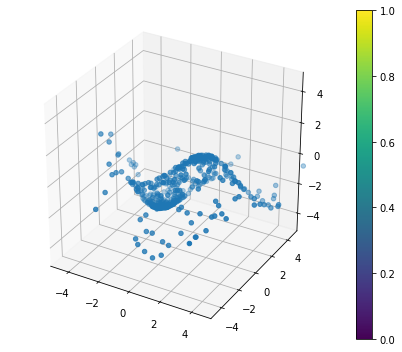

In [13]:
plot_gen(0, 0)

## Generated samples

In [14]:
def show_corner(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_test.npy")
        _ = corner.corner(x, range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
    else:
        print(algo_labels[algo])
        _ = corner.corner(x_gen[algo][show], range=[(-boundary, boundary) for _ in range(3)], bins=10)
        
        
def show_scatter(algo=None, show=0, boundary=1.5):
    if algo is None:
        print("Simulator")
        x = np.load("../data/samples/spherical_gaussian/spherical_gaussian_2_3_0.010_x_train.npy")[:1000]
    else:
        print(algo_labels[algo])
        x = x_gen[algo][show][:1000]
        
    fig = plt.figure(figsize=(5,5))
    ax = Axes3D(fig)
    ax.scatter(x[:,0], x[:,1], x[:,2])
    
    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_zlabel("$x_2$")
    
    plt.show()    

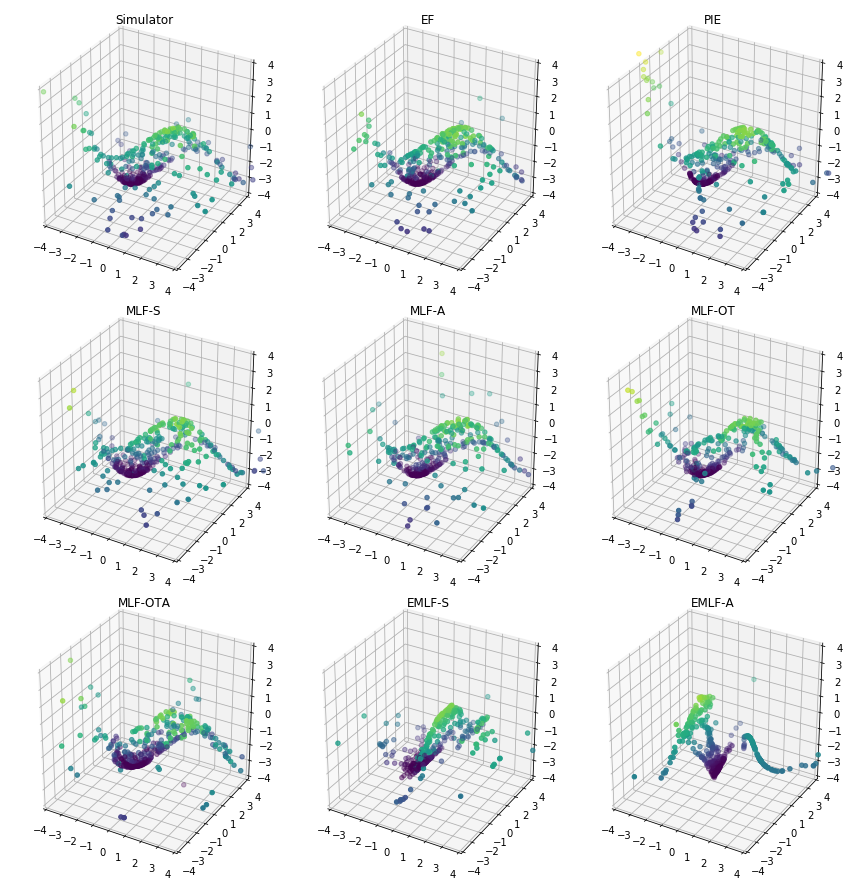

In [15]:
cmin, cmax = -3.,3.
boundary = 4.0
run = 1

ncols = 3
nrows = len(algo_labels) // ncols + 1

fig = plt.figure(figsize=(ncols*4., nrows*4.1))

for panel, algo in enumerate(range(-1, len(algo_labels))):
    if algo < 0:
        x = test_x[run, :400]
    else:
        if model_gen_x[algo][run] is None:
            continue
        else:
            x = model_gen_x[algo][run][:400]

    logp = np.clip(
        test_logp[run, 50, :400] if algo < 0 else model_gen_logp[algo, run, :400],
        cmin, cmax
    )
    d = np.clip(
        np.zeros(x.shape[0]) if algo < 0 else model_gen_distance[algo, run, :400],
        cmin, cmax
    )
    
    ax = fig.add_subplot(nrows, ncols, panel + 1, projection="3d")
    ax.scatter(x[:,0], x[:,1], x[:,2], c=x[:,2], cmap="viridis", vmin=cmin, vmax=cmax)

    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    ax.set_zlim(-boundary, boundary)
    
    ax.set_title("Simulator" if algo < 0 else algo_labels[algo])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/power_generated_samples_3d.pdf")


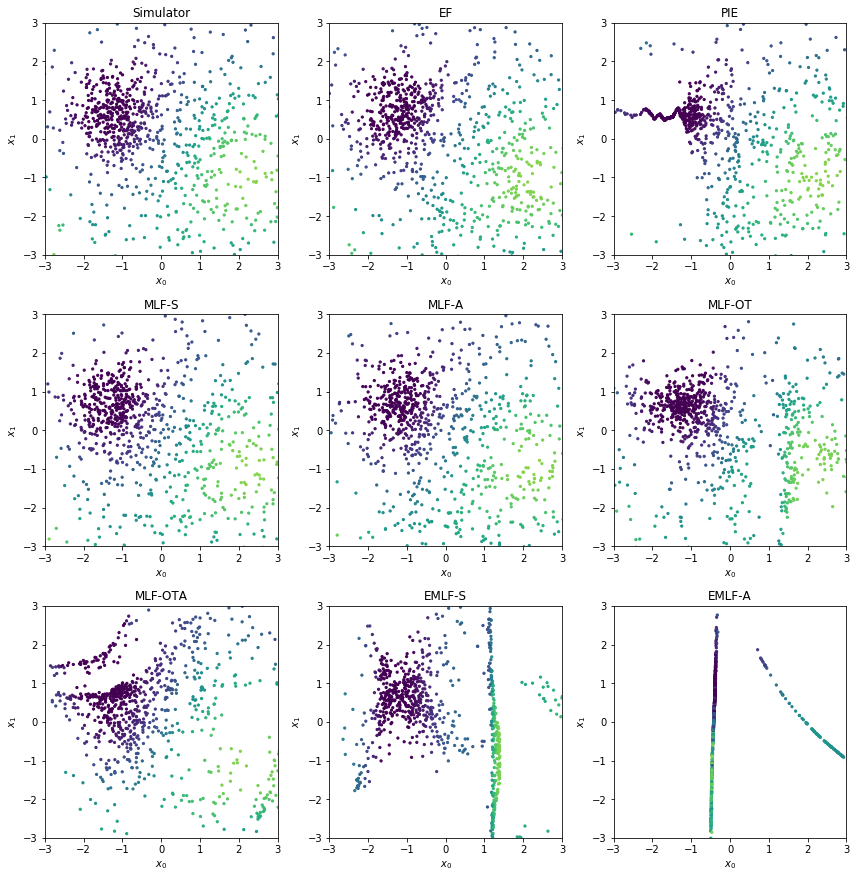

In [16]:
cmin, cmax = -3., 3.
boundary = 3.0
run = 1
n = 1000

ncols = 3
nrows = len(algo_labels) // ncols + 1

fig = plt.figure(figsize=(ncols*4., nrows*4.1))

for panel, algo in enumerate(range(-1, len(algo_labels))):
    if algo < 0:
        x = test_x[run, :n]
    else:
        if model_gen_x[algo][run] is None:
            continue
        else:
            x = model_gen_x[algo][run][:n]

    logp = np.clip(
        test_logp[run, 50, :n] if algo < 0 else model_gen_logp[algo, run, :n],
        cmin, cmax
    )
    
    ax = fig.add_subplot(nrows, ncols, panel + 1)
    plt.scatter(x[:,0], x[:,1], c=x[:,2], cmap="viridis", s=5., vmin=cmin, vmax=cmax)

    ax.set_xlim(-boundary, boundary)
    ax.set_ylim(-boundary, boundary)
    
    ax.set_title("Simulator" if algo < 0 else algo_labels[algo])
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")

plt.tight_layout()
plt.savefig("../figures/power_generated_samples_2d.pdf")


## Plot eval likelihood on test samples

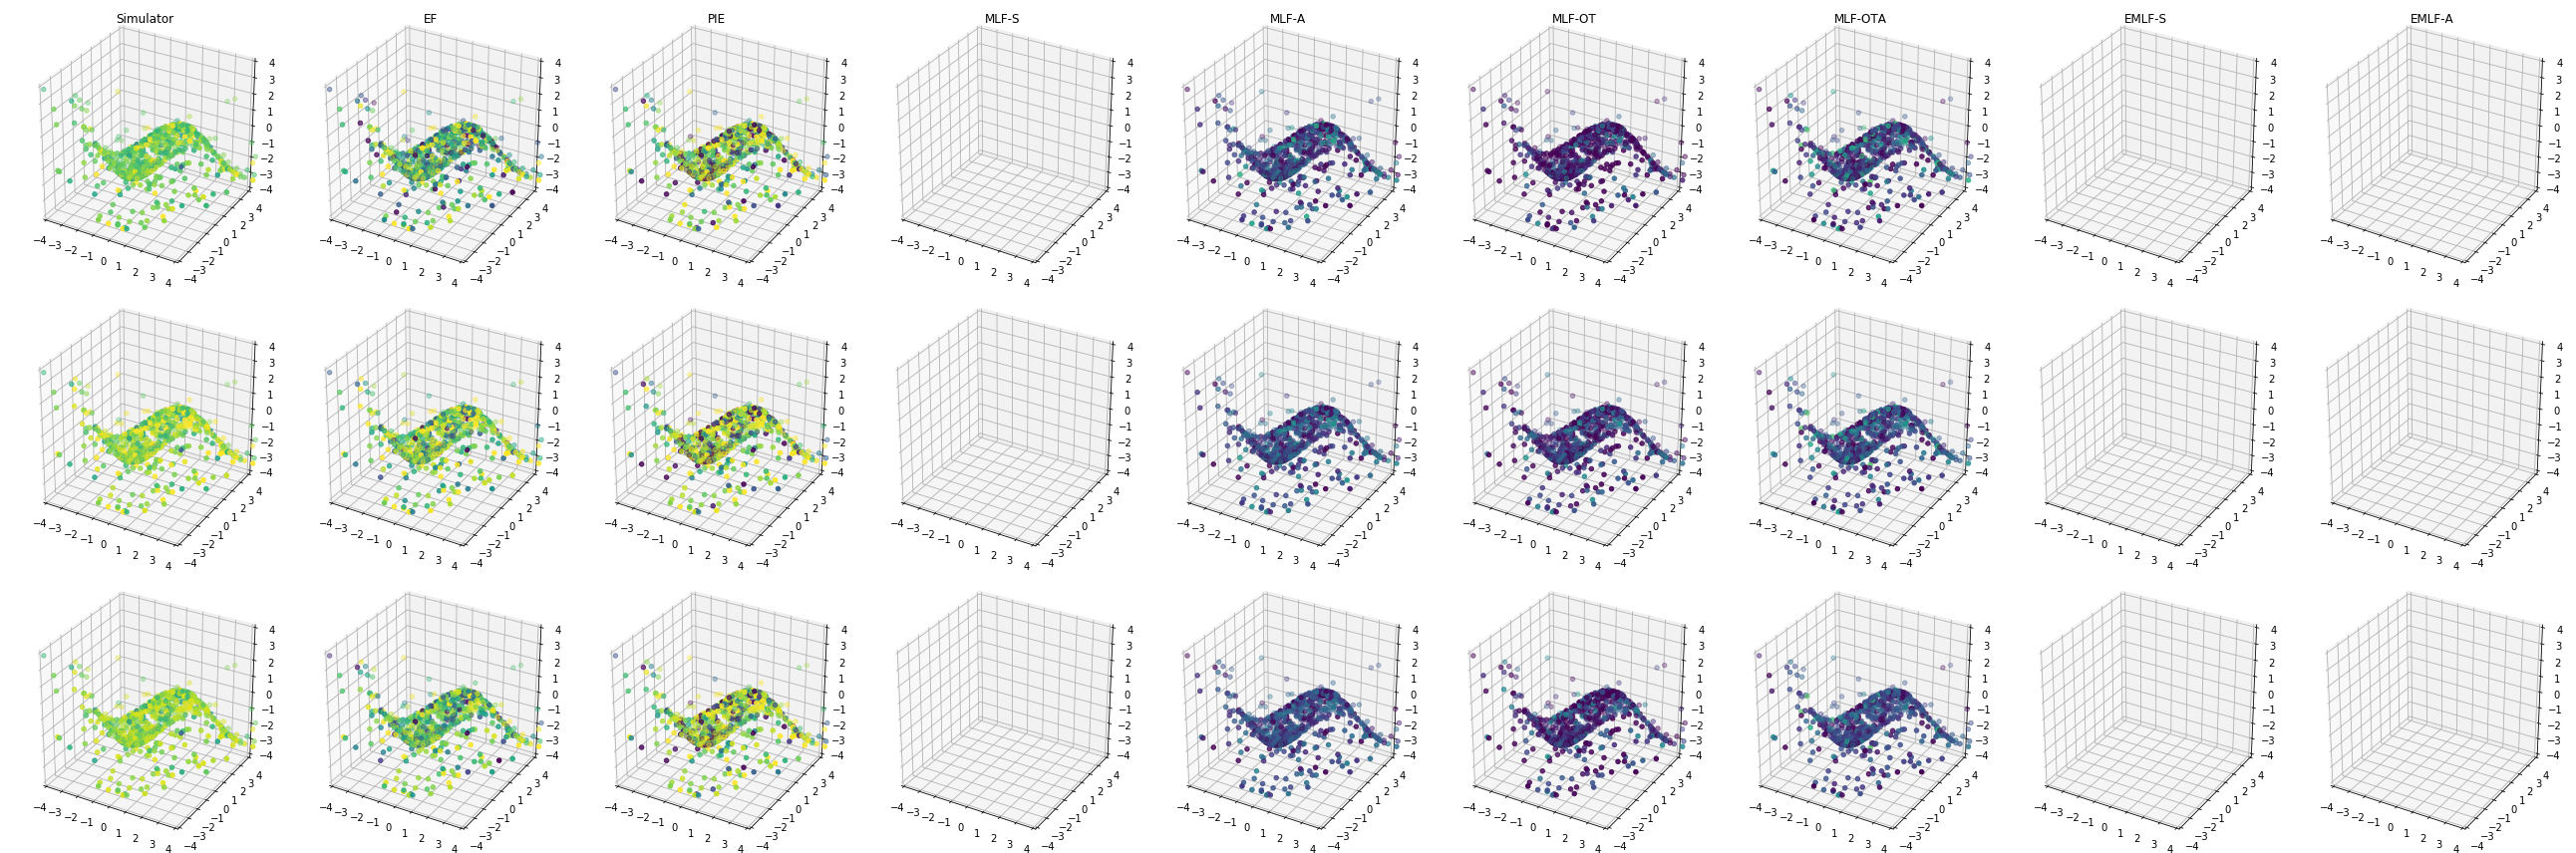

In [17]:
cmin, cmax = -6., 4.
boundary = 4.0
param_points = [0, 50, 100]
run = 1
n = 1000

ncols = len(algo_labels) + 1
nrows = len(param_points)

fig = plt.figure(figsize=(ncols*4, nrows*4))

for col, algo in enumerate(range(-1, len(algo_labels))):
    for row, param in enumerate(param_points):
        x = test_x[run, :n]
        if algo > 0 and model_test_logp[algo, run] is None:
            continue
        else:
            logp = np.clip(
                test_logp[run, param, :n] if algo < 0 else model_test_logp[algo, run, param, :n],
                cmin, cmax
            )
        
        ax = fig.add_subplot(nrows, ncols, row * ncols + col + 1, projection="3d")
        ax.scatter(x[:,0], x[:,1], x[:,2], c=logp, vmin=cmin, vmax=cmax, cmap="viridis")

        ax.set_xlim(-boundary, boundary)
        ax.set_ylim(-boundary, boundary)
        ax.set_zlim(-boundary, boundary)
        
        if row == 0:
            ax.set_title("Simulator" if algo < 0 else algo_labels[algo])
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_zlabel("")

plt.tight_layout()
plt.savefig("../figures/power_test_likelihood_3d.pdf")


## Likelihood estimation quality

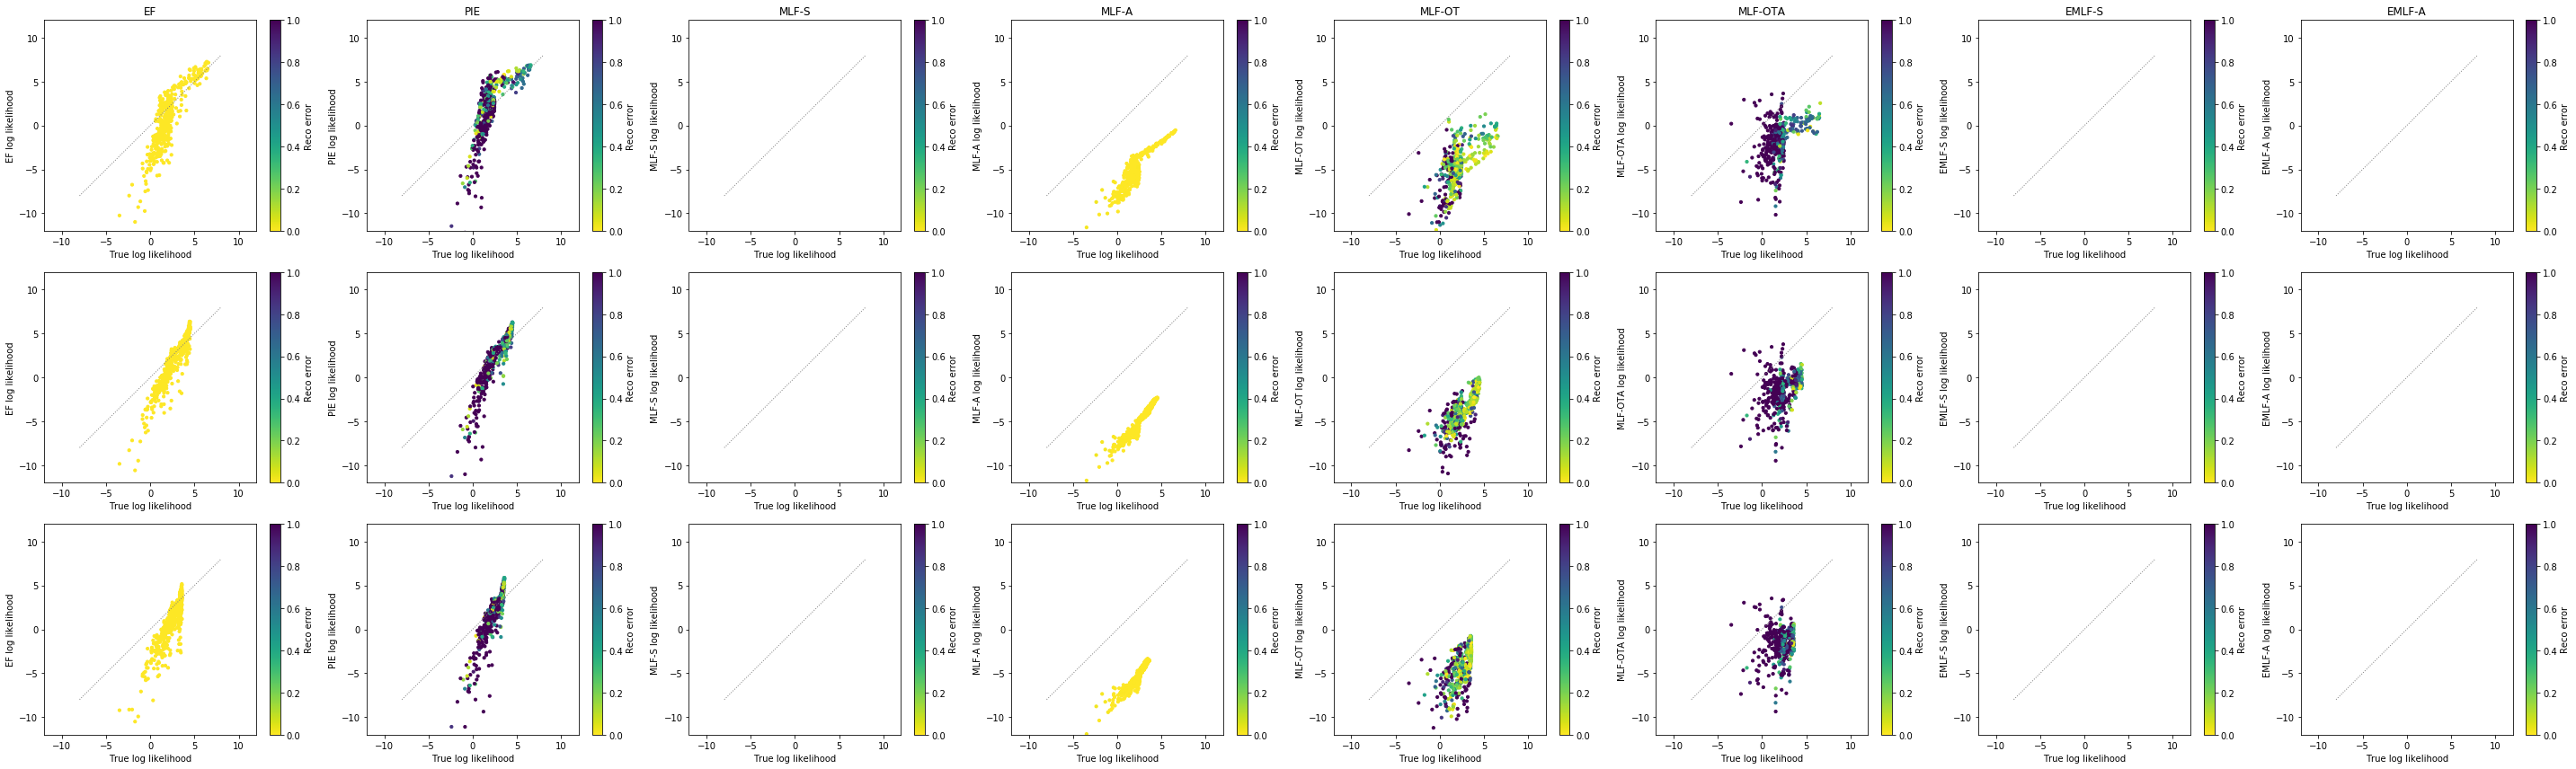

In [18]:
run = 0
param_points = [0, 50, 100]

ncols = len(algo_labels)
nrows = len(param_points)

fig = plt.figure(figsize=(ncols*5, nrows*4))

for col, algo_label in enumerate(algo_labels):
    for row, param in enumerate(param_points):
        ax = plt.subplot(nrows, ncols, row*ncols + col + 1)
        
        plt.plot([-8, 8.], [-8.,8.], ls=":", c="0.5", lw=1.)
        sc = plt.scatter(
            test_logp[run, param, :500],
            model_test_logp[col, run, param, :500],
            # c=np.log(np.clip(model_test_reco_error[col, setting,:500], np.exp(-10.), np.exp(10.))),
            c=model_test_reco_error[col, run, :500],
            s=10.,
            label=algo_label,
            cmap="viridis_r",
            vmin=0., vmax=1.
        )
        cbar = plt.colorbar(sc)
        
        plt.xlabel(r"True log likelihood")
        plt.ylabel(r"{} log likelihood".format(algo_label))
        cbar.set_label('Reco error')
        
        if row == 0:
            ax.set_title(algo_label)
        
        plt.xlim(-12.,12.)
        plt.ylim(-12.,12.)
    
plt.tight_layout()
plt.savefig("../figures/power_test_likelihood_scatter.pdf")


## OOD detection

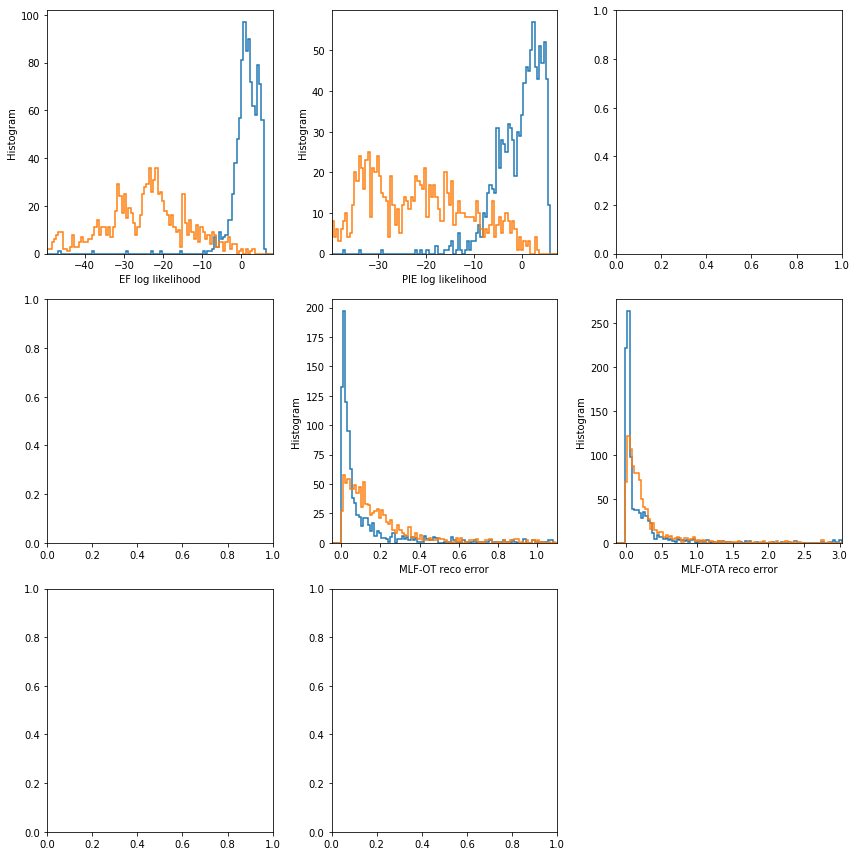

In [24]:
run = 2

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*4, nrows*4))

for algo, algo_label in enumerate(algo_labels):
    ax = plt.subplot(nrows, ncols, algo + 1)

    logp = model_test_logp[algo, run, 50]
    logp_ood = model_ood_logp[algo, run, 50]
    err = model_test_reco_error[algo, run]
    err_ood = model_ood_reco_error[algo, run]
    
    if np.any(np.isnan(logp)):
        continue

    use_err = model_auc_use_err[algo, run]
    x = err if use_err else logp
    x_ood = err_ood if use_err else logp_ood
    
    xmin, xmax = np.percentile(np.concatenate((x, x_ood)), (2., 98.))
    xmin -= (xmax - xmin)*0.05
    xmax += (xmax - xmin)*0.05

    plt.hist(x, color="C0", bins=100, range=(xmin, xmax), histtype="step", lw=1.5)
    plt.hist(x_ood, color="C1", bins=100, range=(xmin, xmax), histtype="step", lw=1.5)

    plt.xlabel(("{} reco error" if use_err else "{} log likelihood").format(algo_label))
    plt.ylabel("Histogram")
    plt.xlim(xmin, xmax)
    plt.ylim(0., None)
    
plt.tight_layout()
plt.savefig("../figures/power_ood_separation.pdf")


## Generative metrics

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


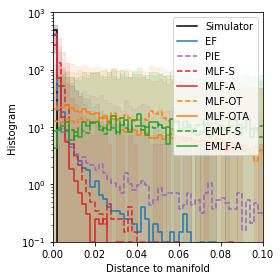

In [20]:
xmin, xmax = 0.,0.1
bins = 50

fig = plt.figure(figsize=(4, 4))
ax = plt.gca()
    
histo_w_err(
    test_distance[run,:],
    xmin, xmax, bins,
    label="Simulator",
    c="black",
)

for algo, (algo_label, c, m, ls) in enumerate(zip(algo_labels, algo_colors, algo_markers, algo_linestyles)):
    histo_w_err(
        model_gen_distance[algo, run, :],
        xmin, xmax, bins,
        label=algo_label,
        c=c,
        ls=ls,
    )

plt.legend()

plt.xlabel(r"Distance to manifold")
plt.ylabel(r"Histogram")
plt.xlim(xmin, xmax)
plt.yscale("log")
plt.ylim(1.e-1, 1.e3)
    
plt.tight_layout()
plt.savefig("../figures/power_generated_samples_distance_distribution.pdf")


## Inference metrics

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


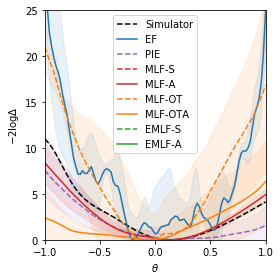

In [21]:
fig = plt.figure(figsize=(4,4))

plot_w_err(param_grid, true_observed_nll.T - np.min(true_observed_nll, axis=1), ls="--", c="black", label="Simulator", subtract_min=True)
for nll, label, c, ls, mmd in zip(model_observed_nll, algo_labels, algo_colors, algo_linestyles, model_mmds):
    logp = nll.T - np.min(nll, axis=1)
    plot_w_err(param_grid, logp, ls=ls, c=c, label=label, subtract_min=True)
    
plt.legend()

plt.xlabel(r"$\theta$")
plt.ylabel(r"$-2 \log \Delta {p(x|\theta)$")

plt.ylim(0., 25.)
plt.xlim(-1.,1.)

plt.tight_layout()
plt.savefig("../figures/power_test_observed_likelihood_maps.pdf")


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


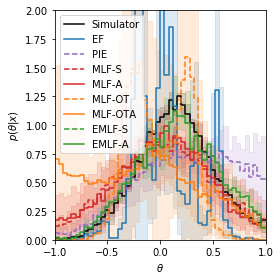

In [22]:
fig = plt.figure(figsize=(4,4))

histo_w_err(
    true_posterior_samples,-1., 1., 50,
    ls="-", c="black", alpha=0.15,
    label="Simulator",
    subtract_min=True, plot_individual=False
)
for posterior, label, c, ls in zip(model_posterior_samples, algo_labels, algo_colors, algo_linestyles):
    histo_w_err(
        posterior, -1., 1., 50,
        ls=ls, c=c, alpha=0.15, 
        label=label,
        subtract_min=True, plot_individual=False
    )
    
plt.legend()

plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta|x)$")

plt.ylim(0., 2.)
plt.xlim(-1.,1.)

plt.tight_layout()
plt.savefig("../figures/power_posterior.pdf")

